# Work Flow

In [11]:
# import necessary libraries
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [43]:
X

,age,delivery_unit_size_raw,hh_active_consumer,hh_actual_hom_evalue,hh_age_0_3,hh_age_13_17,hh_age_4_7,hh_age_8_12,hh_allergies,hh_alzheimers,...,"zip_code_(20,[16],[1.0])","zip_code_(20,[17],[1.0])","zip_code_(20,[18],[1.0])","zip_code_(20,[1],[1.0])","zip_code_(20,[2],[1.0])","zip_code_(20,[3],[1.0])","zip_code_(20,[5],[1.0])","zip_code_(20,[6],[1.0])","zip_code_(20,[7],[1.0])","zip_code_(20,[8],[1.0])"
0,69.0,1,4,80.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,67.0,1,9,50.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,73.0,1,1,141.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,38.0,1,0,92.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,67.0,1,6,163.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,70.0,1,4,87.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,71.0,1,5,96.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,26.0,1,0,60.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,53.0,4,1,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,49.0,1,3,99.0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
self.X = pd.DataFrame(skb.transform(X), columns=['SV %i' % i for i in range(k)], index=self.X.index)  

## Load data

In [37]:
# import data which was subset using R
df_y6= pd.read_csv('/home/cristianromero/Documents/Datasets/kantar_6_targets.csv')
df_x6= pd.read_csv('/home/cristianromero/Documents/Datasets/kantar_6_features.csv')
# remove extra id columns
df_y6=df_y6.iloc[:,1]
df_x6=df_x6.iloc[:,1:len(df_x6)]

df_y11= pd.read_csv('/home/cristianromero/Documents/Datasets/kantar_11_targets.csv')
df_x11= pd.read_csv('/home/cristianromero/Documents/Datasets/kantar_11_features.csv')
# remove extra id columns
df_y11=df_y11.iloc[:,1]
df_x11=df_x11.iloc[:,1:len(df_x11)]

# handle missing data
# drop column 'hh_boat_length', it is filled with an extraordinary amount of NA
df_x6 = df_x6.drop(columns="hh_boat_length")
df_x11 = df_x11.drop(columns="hh_boat_length")
# # fill remaining, scattered missing values with 0 (fill with mean/mode in future?)
df_x6=df_x6.fillna(0)
df_x11=df_x11.fillna(0)

In [38]:
# set working dataframe

X= df_x6
y= df_y6

# X= df_x11
# y= df_y11

print(X.shape)

(8930, 175)


## Low variance filter

In [23]:
# check variance of each column
# remove column if variance is less than var_threshold
from numpy import var
drop=[]
var_threshold = 0.004975
for col in X.columns:
    if X[col].dtype!='object': 
        if var(X[col]) < var_threshold:
            drop.append(col)

X=X.drop(columns=drop)

In [24]:
X.shape

(8930, 173)

## PCC filter (optional)

In [166]:
# check pearson coefficient for linear correlation between DV and each feature 
# remove column if PCC is less than correlation limit
# column bind
df=pd.concat([y, X], axis=1, ignore_index=True)

# create pearson correlation matrix
cor = df.corr()

# define correlation criteria
corr_limit=0.1

# check correlation with output variable
cor_target = abs(cor.iloc[:,0])

# select highly correlated features
relevant_features = cor_target[cor_target>corr_limit]
# drop first element (shows correlation with self)
relevant_features=relevant_features.iloc[1:]

# initiate list with index of relevant columns
rel_col =[]
# fix off-by-one indexing error (introduced when concatenating DV in corr matrix)
for i in relevant_features.index:
    rel_col.append(i-1) 

# drop all columns except relevant ones
X=X.iloc[:,rel_col]

In [167]:
# check pearson coefficient for linear correlation between features (collinearity)
# remove if PCC is greater than collinear limit

# recreate pearson correlation matrix
cor = X.corr()
# initialize storing lists
feat_targets=[]
feat_remove=[]
ignore=[]
# set correlation limit
colinear_corr_limit=0.95

# check for collinearity
for i in X.columns:
    cor_target = abs(cor.loc[:,i])
    feat_targets.append((i,
                   cor_target[cor_target>colinear_corr_limit]))  
# remove collinear features
for i in feat_targets:
    ignore.append(i[0])
for j in i[1].index:
    if j not in ignore:
        feat_remove.append(j)

feat_remove=set(feat_remove)
X=X.drop(columns=feat_remove)

In [168]:
# check which columns are kept 
keep_col=X.columns
print(keep_col)
print(len(keep_col))

Index(['hh_heavy_internet_user', 'hh_internet_usage'], dtype='object')
2


## Encode categorical variables

In [39]:
# encode
X=pd.get_dummies(X)

# check shape
print(X.shape)

(8930, 339)


## Split

In [107]:
# split testing and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## RFE

In [98]:

#X_test = rfe.transform(X_test)

In [108]:
keep=[]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe = RFE(estimator=LogisticRegression(), n_features_to_select = 338)
rfe = rfe.fit(X_train,y_train)
for i in range(0,len(rfe.support_)) :
    if rfe.support_[i]==True:
        keep.append(i)
X_train=X_train.iloc[:,keep]
X_test=X_test.iloc[:,keep]

/home/cristianromero/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/cristianromero/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [ ]:
for i in range(0,len(X.columns)):
    if percent_missing[i]>percent_threshold:
        column_name.append(percent_missing.index[i])

In [147]:
percent_missing = X.isnull().sum() * 100 / len(X)

In [148]:
column_name = [percent_missing.index[i] for i in range(0,len(X.columns)) if percent_missing[i]>0]

In [149]:
column_name

['age',
 'hh_actual_hom_evalue',
 'hh_average_worker_travel_time',
 'hh_home_equity_estimate',
 'hh_median_rent_as_pcnt_of_hh_income',
 'hh_ownrent',
 'hh_pcnt_hh_income_150k_plus',
 'hh_pcnt_housing_300k_plus',
 'hh_pcnt_income_public_assistance',
 'hh_pcnt_pop_professional_occupation',
 'hh_pcnt_poverty',
 'hh_pcnt_self_employed',
 'hh_pcnt_total_work_16_plus_use_public_trans',
 'hh_pcnt_unemployed',
 'hh_pcnt_workers_work_at_home',
 'hh_revolver_to_transactor',
 'hh_vehicles_per_hh',
 'ind_number_of_trade_lines']

## TSVD (optional)

In [122]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=20, n_iter=7, random_state=42)
# perform tsvd on test and train sets
svd=svd.fit(X)

AttributeError: 'TruncatedSVD' object has no attribute 'singular_value_'

In [124]:
svd.components_

array([[ 9.54505364e-11,  8.24875972e-12,  1.43871368e-12, ...,
         2.83405028e-16,  3.24142795e-16,  2.02604221e-16],
       [ 5.77535819e-07,  5.50655015e-08,  9.12810725e-09, ...,
        -9.20971764e-13, -9.05484722e-13,  4.69559517e-12],
       [-7.75154610e-07,  5.47221682e-08, -2.32702475e-08, ...,
        -1.58221048e-11,  2.12069622e-11,  2.51722276e-11],
       ...,
       [-3.67098369e-01, -2.92043181e-01, -4.99569760e-03, ...,
        -6.89633378e-06,  9.95100368e-07, -9.43325380e-06],
       [-5.34193924e-01,  4.31206561e-01, -1.17378321e-02, ...,
         1.65577645e-05,  2.89799992e-06, -2.78645983e-06],
       [-4.66423562e-01, -2.46952549e-02, -6.34021780e-03, ...,
         7.20552995e-06,  1.13460532e-05, -9.92017456e-06]])

## PCA (optional)

In [99]:
from sklearn.decomposition import PCA

pca = PCA(n_components=24, random_state=42)
# perform tsvd on test and train sets
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test) 

## Sample

Classes: [0 1]
Counts: [5338 5338]
Proportion: 1.0 : 1.0


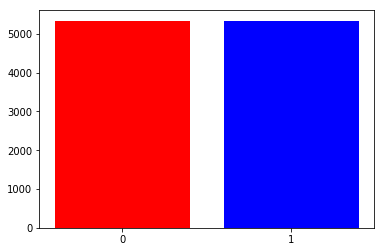

In [27]:
# ROS  
from imblearn.over_sampling import RandomOverSampler

#ROS
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

# check that sampling worked
unique_elements, counts_elements = np.unique(y_ros, return_counts=True)
print('Classes:',unique_elements)
print('Counts:',counts_elements)
print('Proportion:', round(counts_elements[0] / counts_elements[1], 2), ': 1.0')
#barplot
plt.bar(unique_elements, counts_elements, color=['red','blue'])
plt.xticks(unique_elements, unique_elements,)
plt.show()

Classes: [0 1]
Counts: [5338 5338]
Proportion: 1.0 : 1.0


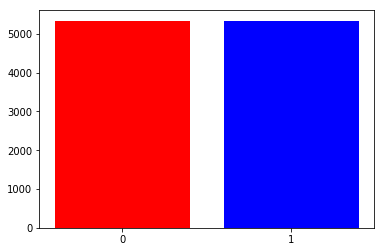

In [28]:
# SMOTE 
from imblearn.over_sampling import SMOTE

# SMOTE (Synthetic Minority Oversampling TEchnique) (sm)
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X_train, y_train)
# check that sampling worked
unique_elements, counts_elements = np.unique(y_sm, return_counts=True)
print('Classes:',unique_elements)
print('Counts:',counts_elements)
print('Proportion:', round(counts_elements[0] / counts_elements[1], 2), ': 1.0')
#barplot
plt.bar(unique_elements, counts_elements, color=['red','blue'])
plt.xticks(unique_elements, unique_elements,)
plt.show()

Classes: [0 1]
Counts: [4582 4582]
Proportion: 1.0 : 1.0


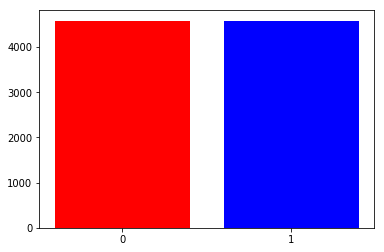

In [29]:
# SMOTE + TL
from imblearn.combine import SMOTETomek

# COMBO oversampling followed by undersampling  (smt)
smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(X_train, y_train)

# check that sampling worked
unique_elements, counts_elements = np.unique(y_smt, return_counts=True)
print('Classes:',unique_elements)
print('Counts:',counts_elements)
print('Proportion:', round(counts_elements[0] / counts_elements[1], 2), ': 1.0')
#barplot
plt.bar(unique_elements, counts_elements, color=['red','blue'])
plt.xticks(unique_elements, unique_elements,)
plt.show()

## Hyperparameter Tuning (optional)

In [67]:
# M11 SVD tune
# Randomized search Random Forest
# ETC = 17 iterations per min
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy import stats

# random search
# instantiate model
model = RandomForestClassifier()


# set hyperparameters to test
bootstrap = [True, False]
n_estimators = [300]
min_impurity_decrease = np.arange(0,8,step=0.2)
max_depth = np.arange(1,90)
max_features = ['auto']
min_samples_split = np.arange(2,25)
np.append(min_samples_split,0)
min_samples_leaf=  np.arange(1,25)
class_weight=['balanced',None]


# input hyperparameters into dictionary
param_grid = dict(bootstrap=bootstrap, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,max_features=max_features,max_depth=max_depth,min_impurity_decrease=min_impurity_decrease, n_estimators=n_estimators,class_weight=class_weight)

# instantiate cv and grid
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=7)
random_search = RandomizedSearchCV(model, param_grid, n_iter=2500, scoring="roc_auc", n_jobs=3, cv=kfold)


# run
random_result = random_search.fit(X_train,y_train)

# summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.575593 using {'n_estimators': 300, 'min_samples_split': 18, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.0, 'max_features': 'auto', 'max_depth': 83, 'class_weight': 'balanced', 'bootstrap': True}
0.500000 (0.000000) with: {'n_estimators': 300, 'min_samples_split': 24, 'min_samples_leaf': 8, 'min_impurity_decrease': 4.6000000000000005, 'max_features': 'auto', 'max_depth': 25, 'class_weight': None, 'bootstrap': True}
0.500000 (0.000000) with: {'n_estimators': 300, 'min_samples_split': 6, 'min_samples_leaf': 20, 'min_impurity_decrease': 4.2, 'max_features': 'auto', 'max_depth': 57, 'class_weight': None, 'bootstrap': True}
0.500000 (0.000000) with: {'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 4, 'min_impurity_decrease': 7.2, 'max_features': 'auto', 'max_depth': 78, 'class_weight': None, 'bootstrap': True}
0.500000 (0.000000) with: {'n_estimators': 300, 'min_samples_split': 24, 'min_samples_leaf': 16, 'min_impurity_decrease': 4.2, 'max_features': 'auto', '

In [7]:
# M6 SVD tune
# Randomized search
# ETC = 17 iterations per min
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy import stats

# random search
# instantiate model
model = RandomForestClassifier()

# set hyperparameters to test
bootstrap = [True, False]
n_estimators = [300]
min_impurity_decrease = np.arange(0,8,step=0.2)
max_depth = np.arange(1,90)
max_features = ['auto']
min_samples_split = np.arange(2,25)
np.append(min_samples_split,0)
min_samples_leaf=  np.arange(1,25)
class_weight=['balanced',None]


# input hyperparameters into dictionary
param_grid = dict(bootstrap=bootstrap, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,max_features=max_features,max_depth=max_depth,min_impurity_decrease=min_impurity_decrease, n_estimators=n_estimators,class_weight=class_weight)

# instantiate cv and grid
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=7)
random_search = RandomizedSearchCV(model, param_grid, n_iter=10, scoring="roc_auc", n_jobs=-1, cv=kfold)


# run
random_result = random_search.fit(X_train,y_train)
print(random_result.best_params_)
# summarize results
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))


{'n_estimators': 300, 'min_samples_split': 23, 'min_samples_leaf': 9, 'min_impurity_decrease': 1.6, 'max_features': 'auto', 'max_depth': 2, 'class_weight': 'balanced', 'bootstrap': True}
Best: 0.500000 using {'n_estimators': 300, 'min_samples_split': 23, 'min_samples_leaf': 9, 'min_impurity_decrease': 1.6, 'max_features': 'auto', 'max_depth': 2, 'class_weight': 'balanced', 'bootstrap': True}
0.500000 (0.000000) with: {'n_estimators': 300, 'min_samples_split': 23, 'min_samples_leaf': 9, 'min_impurity_decrease': 1.6, 'max_features': 'auto', 'max_depth': 2, 'class_weight': 'balanced', 'bootstrap': True}
0.500000 (0.000000) with: {'n_estimators': 300, 'min_samples_split': 18, 'min_samples_leaf': 9, 'min_impurity_decrease': 3.8000000000000003, 'max_features': 'auto', 'max_depth': 42, 'class_weight': 'balanced', 'bootstrap': False}
0.500000 (0.000000) with: {'n_estimators': 300, 'min_samples_split': 19, 'min_samples_leaf': 1, 'min_impurity_decrease': 2.2, 'max_features': 'auto', 'max_depth':

In [32]:
# Bayesian Optimization 
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold

# instantiate model
model = RandomForestClassifier()

# set hyperparameters to test
bootstrap = Categorical([True, False])
n_estimators = [300]
min_impurity_decrease = [0]
max_depth = Integer(1,100)
max_features = Categorical(['auto'])
min_samples_split = Integer(2,30)
np.append(min_samples_split,0)
min_samples_leaf=  Integer(1,30)
class_weight=Categorical(['balanced',None])


# input hyperparameters into dictionary
param_grid = dict(bootstrap=bootstrap, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,max_features=max_features,max_depth=max_depth,min_impurity_decrease=min_impurity_decrease, n_estimators=n_estimators,class_weight=class_weight)

# instantiate cv and grid
kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=7)
grid_search = BayesSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold, n_iter=100,verbose=False)

# run
grid_result = grid_search.fit(X,y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

/home/cristianromero/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/cristianromero/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


KeyboardInterrupt: 

In [ ]:
# Exhaustive grid search 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# grid search
# instantiate model
model = RandomForestClassifier()

# set hyperparameters to test
n_estimators = [250, 500, 800]
learning_rate = [0.1]
colsample_bytree= [0.2, 0.4, 0.8]
subsample=[0.5, 0.8, 1]
max_depth=[5,15]
alpha=[1,10,20]
Scale_pos_weight=[8,4,1,0.25]

# input hyperparameters into dictionary
param_grid = dict(alpha=alpha,max_depth=max_depth,Scale_pos_weight=Scale_pos_weight,learning_rate=learning_rate, n_estimators=n_estimators,colsample_bytree=colsample_bytree, subsample=subsample)

# instantiate cv and grid
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold)

# run
grid_result = grid_search.fit(X,y)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

## Choose ML Model

In [153]:
# Best hyperparameter options (F1 optimized):
# Best: 0.431820 using {'n_estimators': 300, 'min_samples_split': 14, 'min_samples_leaf': 13, 'min_impurity_decrease': 0.0, 'max_features': 'auto', 'max_depth': 5, 'class_weight': 'balanced', 'bootstrap': False}

# Best hyperparameter options (AUC optimized):
# Best: 0.8699809358559589 using {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': array([43]), 'max_features': array([0.11469355]), 'min_impurity_decrease': 0, 'min_samples_leaf': array([0.00259294]), 'min_samples_split': array([0.03653847])
# Best: 0.642812 using {'n_estimators': 300, 'min_samples_split': 9, 'min_samples_leaf': 9, 'min_impurity_decrease': 0.0, 'max_features': 'auto', 'max_depth': 41, 'class_weight': None, 'bootstrap': True}

In [ ]:
# M11 PCA hyperparameters (auc optimized):
# Best: 0.579530 using {'n_estimators': 300, 'min_samples_split': 16, 'min_samples_leaf': 19, 'min_impurity_decrease': 0.0, 'max_features': 'auto', 'max_depth': 37, 'class_weight': 'balanced', 'bootstrap': True}

# M11 SVD hyperparameters (auc optimized):
# Best: 0.575593 using {'n_estimators': 300, 'min_samples_split': 18, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.0, 'max_features': 'auto', 'max_depth': 83, 'class_weight': 'balanced', 'bootstrap': True}

In [ ]:
# M6 PCA hyperparameters (auc optimized):
# Best: 0.620170 using {'n_estimators': 300, 'min_samples_split': 15, 'min_samples_leaf': 22, 'min_impurity_decrease': 0.0, 'max_features': 'auto', 'max_depth': 56, 'class_weight': None, 'bootstrap': True}

# M6 SVD hyperparameters (auc optimized):
# Best: 0.619696 using {'n_estimators': 300, 'min_samples_split': 14, 'min_samples_leaf': 18, 'min_impurity_decrease': 0.0, 'max_features': 'auto', 'max_depth': 5, 'class_weight': 'balanced', 'bootstrap': True}

In [43]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 500 decision trees
model = RandomForestClassifier(n_estimators = 350, 
                            bootstrap=True,
                            criterion='gini',
                            max_depth=43,
                            min_samples_split=0.03653847,
                            max_features=0.11469355,
                            min_samples_leaf=0.00259294,
                            min_impurity_decrease=0,
                            class_weight='balanced_subsample')

In [ ]:
# Best hyperparameter options (F1 optimized):



In [ ]:
# svm non-linear kernel
from sklearn.svm import  NuSVC

model = NuSVC(nu=0.5, 
            kernel=’rbf’,
            degree=3,
            gamma=’auto_deprecated’,
            coef0=0.0,
            shrinking=True,
            probability=False,
            tol=0.001,
            cache_size=200,
            class_weight=None,
            verbose=False,
            max_iter=-1,
            decision_function_shape=’ovr’,
            random_state=None)

In [ ]:
# Best hyperparameter options (F1 optimized):




In [ ]:
# linear svm
from sklearn.svm import LinearSVC

model = LinearSVC(penalty=’l2’, 
            loss=’squared_hinge’,
            dual=True,
            tol=0.0001,
            C=1.0,
            multi_class=’ovr’,
            fit_intercept=True,
            intercept_scaling=1,
            class_weight=None,
            verbose=0,
            random_state=None,
            max_iter=1000)

## Train/Test

In [44]:
# Train the model on training data
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=43, max_features=0.11469355,
            max_leaf_nodes=None, min_impurity_decrease=0,
            min_impurity_split=None, min_samples_leaf=0.00259294,
            min_samples_split=0.03653847, min_weight_fraction_leaf=0.0,
            n_estimators=350, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [45]:
from sklearn.metrics import classification_report

# Use the forest's predict method on the test data
preds = model.predict(X_test)

# Calculate the absolute errors
errors = abs(preds - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# print performance metrics
print(classification_report(y_test,preds))

Mean Absolute Error: 0.36 degrees.
              precision    recall  f1-score   support

           0       0.80      0.67      0.73      1302
           1       0.38      0.55      0.45       484

   micro avg       0.64      0.64      0.64      1786
   macro avg       0.59      0.61      0.59      1786
weighted avg       0.69      0.64      0.65      1786



Confusion matrix:
 [[870 432]
 [218 266]]
 
Accuracy: 63.61%
Precision:      0.38109
Recall:         0.54959
Specificity:    0.6682
Neg Pred Val:   0.79963
 
Confusion Sum:  2.39851
F1 score:       0.45009
F2 score:       0.50494
MCC:            0.19839
AUC:            0.6088947709182313
RMSE:           0.6032758650210609


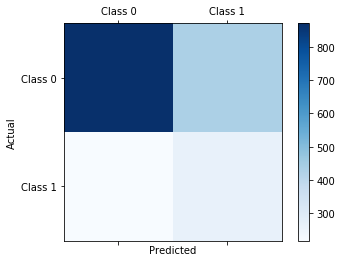

In [46]:
# more performance metrics
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

conf_mat = confusion_matrix(y_true=y_test, y_pred=preds)
accuracy = accuracy_score(y_test, preds)
precision= round(conf_mat[1][1] / (conf_mat[0][1]+conf_mat[1][1]),5)
recall= round(conf_mat[1][1] / (conf_mat[1][0]+conf_mat[1][1]),5)
specificity=round(conf_mat[0][0] / (conf_mat[0][0]+conf_mat[0][1]),5)
neg_pred= round(conf_mat[0][0] / (conf_mat[0][0]+conf_mat[1][0]),5)
f1=round(2*((precision*recall)/(precision+recall)),5)
f2=round(5*((precision*recall)/((4*precision)+recall)),5)
mcc = round(((conf_mat[1][1]*conf_mat[0][0])-(conf_mat[0][1]*conf_mat[1][0]))/np.sqrt((conf_mat[1][1]+conf_mat[1][0])*(conf_mat[1][1]+conf_mat[0][1])*(conf_mat[0][0]+conf_mat[0][1])*(conf_mat[0][0]+conf_mat[1][0])),5)
rmse = np.sqrt(mean_squared_error(y_test, preds))
auc=roc_auc_score(y_test, preds)

print('Confusion matrix:\n', conf_mat)
print(' ')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Precision:     ', precision)
print('Recall:        ', recall)
print('Specificity:   ', specificity)
print('Neg Pred Val:  ', neg_pred)
print(' ')
print('Confusion Sum: ', precision+recall+specificity+neg_pred)
print('F1 score:      ', f1)
print('F2 score:      ', f2)
print('MCC:           ', mcc)
print("AUC:           ", auc)
print("RMSE:          ", rmse)



labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [47]:
# Train the model on training data
model.fit(X_sm, y_sm)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=43, max_features=0.11469355,
            max_leaf_nodes=None, min_impurity_decrease=0,
            min_impurity_split=None, min_samples_leaf=0.00259294,
            min_samples_split=0.03653847, min_weight_fraction_leaf=0.0,
            n_estimators=350, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [48]:
from sklearn.metrics import classification_report

# Use the forest's predict method on the test data
preds = model.predict(X_test)

# Calculate the absolute errors
errors = abs(preds - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# print performance metrics
print(classification_report(y_test,preds))

Mean Absolute Error: 0.29 degrees.
              precision    recall  f1-score   support

           0       0.74      0.93      0.82      1302
           1       0.41      0.13      0.20       484

   micro avg       0.71      0.71      0.71      1786
   macro avg       0.57      0.53      0.51      1786
weighted avg       0.65      0.71      0.66      1786



Confusion matrix:
 [[1207   95]
 [ 419   65]]
 
Accuracy: 71.22%
Precision:      0.40625
Recall:         0.1343
Specificity:    0.92704
Neg Pred Val:   0.74231
 
Confusion Sum:  2.2099
F1 score:       0.20187
F2 score:       0.15506
MCC:            0.09546
AUC:            0.5306664254611468
RMSE:           0.5364643072633306


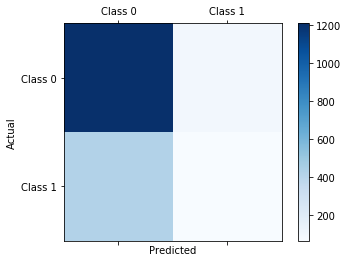

In [49]:
# more performance metrics
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

conf_mat = confusion_matrix(y_true=y_test, y_pred=preds)
accuracy = accuracy_score(y_test, preds)
precision= round(conf_mat[1][1] / (conf_mat[0][1]+conf_mat[1][1]),5)
recall= round(conf_mat[1][1] / (conf_mat[1][0]+conf_mat[1][1]),5)
specificity=round(conf_mat[0][0] / (conf_mat[0][0]+conf_mat[0][1]),5)
neg_pred= round(conf_mat[0][0] / (conf_mat[0][0]+conf_mat[1][0]),5)
f1=round(2*((precision*recall)/(precision+recall)),5)
f2=round(5*((precision*recall)/((4*precision)+recall)),5)
mcc = round(((conf_mat[1][1]*conf_mat[0][0])-(conf_mat[0][1]*conf_mat[1][0]))/np.sqrt((conf_mat[1][1]+conf_mat[1][0])*(conf_mat[1][1]+conf_mat[0][1])*(conf_mat[0][0]+conf_mat[0][1])*(conf_mat[0][0]+conf_mat[1][0])),5)
rmse = np.sqrt(mean_squared_error(y_test, preds))
auc=roc_auc_score(y_test, preds)

print('Confusion matrix:\n', conf_mat)
print(' ')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Precision:     ', precision)
print('Recall:        ', recall)
print('Specificity:   ', specificity)
print('Neg Pred Val:  ', neg_pred)
print(' ')
print('Confusion Sum: ', precision+recall+specificity+neg_pred)
print('F1 score:      ', f1)
print('F2 score:      ', f2)
print('MCC:           ', mcc)
print("AUC:           ", auc)
print("RMSE:          ", rmse)



labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [50]:
# Train the model on training data
model.fit(X_smt, y_smt)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=43, max_features=0.11469355,
            max_leaf_nodes=None, min_impurity_decrease=0,
            min_impurity_split=None, min_samples_leaf=0.00259294,
            min_samples_split=0.03653847, min_weight_fraction_leaf=0.0,
            n_estimators=350, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [51]:
from sklearn.metrics import classification_report

# Use the forest's predict method on the test data
preds = model.predict(X_test)

# Calculate the absolute errors
errors = abs(preds - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# print performance metrics
print(classification_report(y_test,preds))

Mean Absolute Error: 0.28 degrees.
              precision    recall  f1-score   support

           0       0.75      0.93      0.83      1302
           1       0.44      0.14      0.22       484

   micro avg       0.72      0.72      0.72      1786
   macro avg       0.59      0.54      0.52      1786
weighted avg       0.66      0.72      0.66      1786



Confusion matrix:
 [[1213   89]
 [ 414   70]]
 
Accuracy: 71.84%
Precision:      0.44025
Recall:         0.14463
Specificity:    0.93164
Neg Pred Val:   0.74554
 
Confusion Sum:  2.26206
F1 score:       0.21773
F2 score:       0.16707
MCC:            0.11904
AUC:            0.538135862182783
RMSE:           0.530692885207494


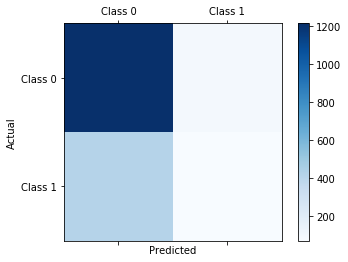

In [52]:
# more performance metrics
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

conf_mat = confusion_matrix(y_true=y_test, y_pred=preds)
accuracy = accuracy_score(y_test, preds)
precision= round(conf_mat[1][1] / (conf_mat[0][1]+conf_mat[1][1]),5)
recall= round(conf_mat[1][1] / (conf_mat[1][0]+conf_mat[1][1]),5)
specificity=round(conf_mat[0][0] / (conf_mat[0][0]+conf_mat[0][1]),5)
neg_pred= round(conf_mat[0][0] / (conf_mat[0][0]+conf_mat[1][0]),5)
f1=round(2*((precision*recall)/(precision+recall)),5)
f2=round(5*((precision*recall)/((4*precision)+recall)),5)
mcc = round(((conf_mat[1][1]*conf_mat[0][0])-(conf_mat[0][1]*conf_mat[1][0]))/np.sqrt((conf_mat[1][1]+conf_mat[1][0])*(conf_mat[1][1]+conf_mat[0][1])*(conf_mat[0][0]+conf_mat[0][1])*(conf_mat[0][0]+conf_mat[1][0])),5)
rmse = np.sqrt(mean_squared_error(y_test, preds))
auc=roc_auc_score(y_test, preds)

print('Confusion matrix:\n', conf_mat)
print(' ')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Precision:     ', precision)
print('Recall:        ', recall)
print('Specificity:   ', specificity)
print('Neg Pred Val:  ', neg_pred)
print(' ')
print('Confusion Sum: ', precision+recall+specificity+neg_pred)
print('F1 score:      ', f1)
print('F2 score:      ', f2)
print('MCC:           ', mcc)
print("AUC:           ", auc)
print("RMSE:          ", rmse)



labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [53]:
# Train the model on training data
model.fit(X_ros, y_ros)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=43, max_features=0.11469355,
            max_leaf_nodes=None, min_impurity_decrease=0,
            min_impurity_split=None, min_samples_leaf=0.00259294,
            min_samples_split=0.03653847, min_weight_fraction_leaf=0.0,
            n_estimators=350, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [54]:
from sklearn.metrics import classification_report

# Use the forest's predict method on the test data
preds = model.predict(X_test)

# Calculate the absolute errors
errors = abs(preds - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# print performance metrics
print(classification_report(y_test,preds))

Mean Absolute Error: 0.37 degrees.
              precision    recall  f1-score   support

           0       0.80      0.65      0.72      1302
           1       0.38      0.57      0.46       484

   micro avg       0.63      0.63      0.63      1786
   macro avg       0.59      0.61      0.59      1786
weighted avg       0.69      0.63      0.65      1786



Confusion matrix:
 [[851 451]
 [207 277]]
 
Accuracy: 63.16%
Precision:      0.38049
Recall:         0.57231
Specificity:    0.65361
Neg Pred Val:   0.80435
 
Confusion Sum:  2.41076
F1 score:       0.45709
F2 score:       0.51989
MCC:            0.20435
AUC:            0.6129619403079813
RMSE:           0.6069769786668839


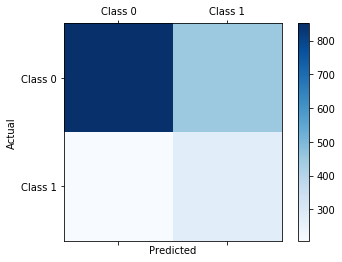

In [55]:
# more performance metrics
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

conf_mat = confusion_matrix(y_true=y_test, y_pred=preds)
accuracy = accuracy_score(y_test, preds)
precision= round(conf_mat[1][1] / (conf_mat[0][1]+conf_mat[1][1]),5)
recall= round(conf_mat[1][1] / (conf_mat[1][0]+conf_mat[1][1]),5)
specificity=round(conf_mat[0][0] / (conf_mat[0][0]+conf_mat[0][1]),5)
neg_pred= round(conf_mat[0][0] / (conf_mat[0][0]+conf_mat[1][0]),5)
f1=round(2*((precision*recall)/(precision+recall)),5)
f2=round(5*((precision*recall)/((4*precision)+recall)),5)
mcc = round(((conf_mat[1][1]*conf_mat[0][0])-(conf_mat[0][1]*conf_mat[1][0]))/np.sqrt((conf_mat[1][1]+conf_mat[1][0])*(conf_mat[1][1]+conf_mat[0][1])*(conf_mat[0][0]+conf_mat[0][1])*(conf_mat[0][0]+conf_mat[1][0])),5)
rmse = np.sqrt(mean_squared_error(y_test, preds))
auc=roc_auc_score(y_test, preds)

print('Confusion matrix:\n', conf_mat)
print(' ')
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print('Precision:     ', precision)
print('Recall:        ', recall)
print('Specificity:   ', specificity)
print('Neg Pred Val:  ', neg_pred)
print(' ')
print('Confusion Sum: ', precision+recall+specificity+neg_pred)
print('F1 score:      ', f1)
print('F2 score:      ', f2)
print('MCC:           ', mcc)
print("AUC:           ", auc)
print("RMSE:          ", rmse)



labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()